# Transfer Learning with ResNet50 for Pneumonia in Chest X-Ray

# Introduction

Recently, artificial intelligence (AI) has also been widely employed in the field of healthcare. Particularly, AI has contributed to medical diagnosis in radiology by convolutional neural network (CNN). CNN has great capacity to classify images such as X-ray images by way of supervised learning. It is expected that AI may facilitate the quality of healthcare services and reduce workload for healthcare professionals.

Here, the dataset provides images as to pneumonia in X-ray and enables analysis regarding to what degree these X-ray images can be classified as normal or pneumonia by machine learning. 

# **Imorting Necessary Libraries**

ResNet50 is a significantly popular and frequently used CNN model for medical AI research. The results of performance by an AI model is generally estimated by classification report and confusion matrix.

In [1]:
import os
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Difining the Paths for Training, Validation, and Testing Data**

In this dataset, the data has already been divided into training, validation, and testing data. Thus, it is not required to split the data for machine learning. However, it is impossible to split the dataset as you wish, which might worsen the results of the classification report.

In [3]:
train_path = '/content/drive/MyDrive/chest_xray/train'
val_path = '/content/drive/MyDrive/chest_xray/val'
test_path = '/content/drive/MyDrive/chest_xray/test'

# **Visualizing the Data**

It is important to see the trend of the data as well as some sample images to decide the best research method to analyze the dataset and the performance of the model.

In [4]:
normal_train_images = glob.glob(train_path + "/NORMAL/*.jpeg")
pneumonia_train_images = glob.glob(train_path + "/PNEUMONIA/*.jpeg")

In [5]:
print(len(normal_train_images))
print(len(pneumonia_train_images))

1341
3875


In [6]:
data = pd.DataFrame(np.concatenate([[0] * len(normal_train_images) , [1] *  len(pneumonia_train_images)]), columns = ["class"])

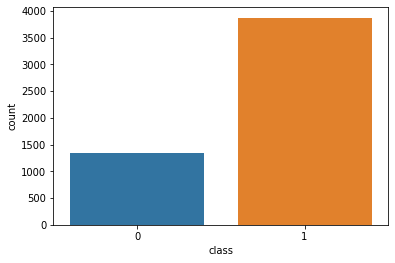

In [7]:
sns.countplot(x = 'class', data = data)

The number of pneumonia images was around three times as much as that of normal images. In the real world, abnormal lung images are much less frequently observed than normal images unless the hospital only collects patients suffering from lung disease.

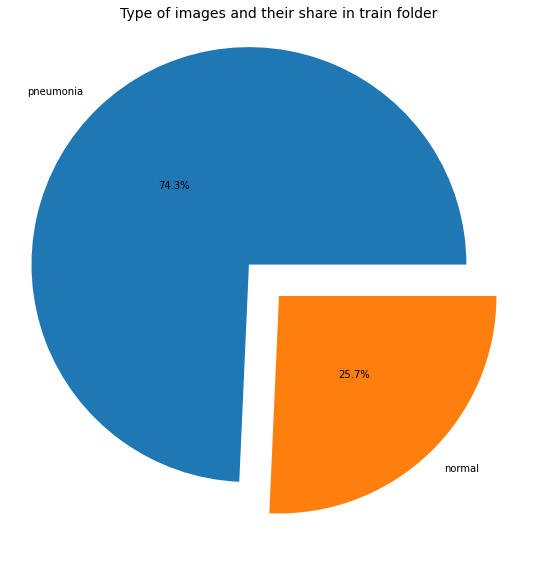

In [8]:
plt.figure(figsize = (15, 10))
plt.pie(x = np.array([len(pneumonia_train_images), len(normal_train_images)]), autopct = "%.1f%%", explode = [0.2, 0], labels = ["pneumonia", "normal"], pctdistance = 0.5)
plt.title("Type of images and their share in train folder", fontsize = 14);

All the samples appeared to be taken from **young children** because the size of the head is relatively big in each image. Maybe the dataset was provided by a pediatrician. I am afraid that this trained model will only be used in pediatrics because **the characteristics of the body are significantly different among ages**.

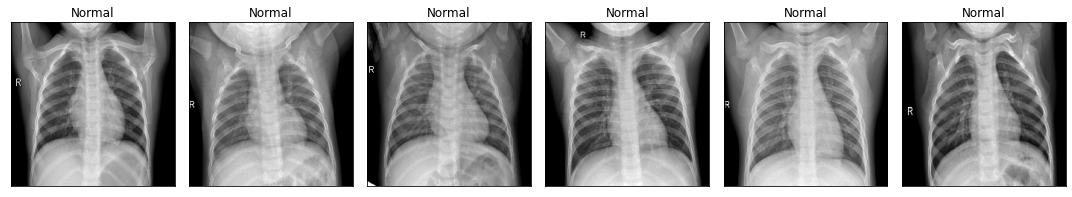

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    

plt.show()

In fact there are roughly several kinds of pneumonias, but the exact diagnosis was not clear. In addition, many patients of abnormal images in the dataset appeared to have **cardiac disease, such as cardiac dilation**. It is not certain how the trained model can analyze abnormal findings in the cardiac part.

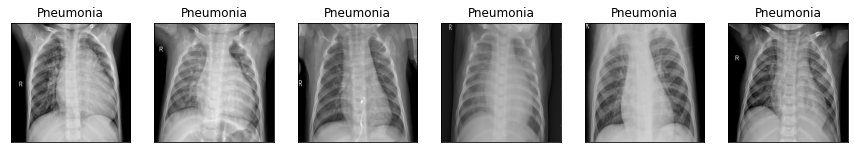

In [10]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512, 512))
    ax.imshow(img)
    ax.set_title("Pneumonia")
    
plt.show()

# **Creating Image Data Generators**

The structure of this dataset is quite simple. The dataset has already been divided into train, validation, and test sets and each set includes normal and pneumonial files of images. Thus, image data generators were easily created. However, **the test set only includes 16 images**. It is not certain whether the model evaluation can be properly performed with the small number of samples.

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   zoom_range = 0.2)
val_datagen = ImageDataGenerator(rescale = 1./255.,)
test_datagen = ImageDataGenerator(rescale = 1./255.,)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (220, 220),
    batch_size = 16,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        test_path,
        target_size = (220,220),
        batch_size = 8,
        class_mode = 'binary'
)
test_generator = test_datagen.flow_from_directory(
    val_path,
    shuffle = False,
    target_size = (220,220),
    batch_size = 32,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


# **Defining the Model**

Here, ResNEt50V2 was employed as the base model for transfer learning. It would be also possible to conduct fine tuning with the model. The choice of hyperparameters depends on the type of task by machine learning. Sigmoid, adam, and binary cross entropy were selected for the final activation function, optimizer, and loss function, respectively.

In [13]:
input_shape = (220, 220, 3)

base_model = tf.keras.applications.ResNet50V2(weights = 'imagenet', input_shape = input_shape, include_top = False)

for layer in base_model.layers:
    layer.trainable = False
    
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer = "adam", loss = 'binary_crossentropy', metrics = ["accuracy"])

94674944/94668760 [==============================] - 1s 0us/step


In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,827,201
Trainable params: 262,401
Non-trainable params: 23,564,800
_________________________________________________________________


# **Training the Model**

The model was trained with the train and validation data. Early stopping was added to prevent overfitting. In fact, it might be preferable to set the larger number of epochs.

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', patience = 4)

history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10, callbacks = callback)

Epoch 1/10
100/100 [==============================] - 688s 7s/step - loss: 0.2813 - accuracy: 0.8819 - val_loss: 0.3058 - val_accuracy: 0.8814
Epoch 2/10
100/100 [==============================] - 454s 5s/step - loss: 0.1661 - accuracy: 0.9394 - val_loss: 0.2829 - val_accuracy: 0.8926
Epoch 3/10
100/100 [==============================] - 386s 4s/step - loss: 0.1583 - accuracy: 0.9406 - val_loss: 0.3032 - val_accuracy: 0.8942
Epoch 4/10
100/100 [==============================] - 348s 3s/step - loss: 0.1362 - accuracy: 0.9450 - val_loss: 0.2562 - val_accuracy: 0.9119
Epoch 5/10
100/100 [==============================] - 339s 3s/step - loss: 0.1098 - accuracy: 0.9569 - val_loss: 0.4758 - val_accuracy: 0.8429
Epoch 6/10
100/100 [==============================] - 341s 3s/step - loss: 0.1521 - accuracy: 0.9394 - val_loss: 0.2542 - val_accuracy: 0.9071
Epoch 7/10
100/100 [==============================] - 335s 3s/step - loss: 0.1266 - accuracy: 0.9513 - val_loss: 0.2840 - val_accuracy: 0.9103

# **Saving the Model**

In [16]:
model.save("model1")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: model1/assets


# **Model Metrics**

The accuracy and loss were calculated for both train and validation data in the model training process.

In [17]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# **Visualizing Accuracy and Loss**

Except for the 4th epoch both the accuracy and loss were constantly improved through the model training. Overfitting was observed in the 4 the epoch, in which the model fitted the training data excessively and did not fit the validation data properly.

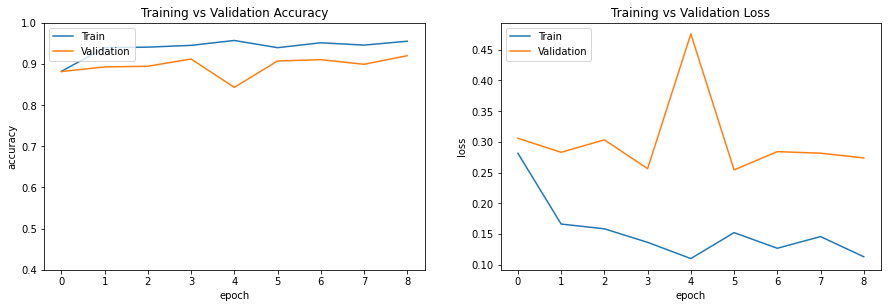

In [18]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# **Predictions**

In order to evaluate the quality of the trained model, the outcome was predicted from the test data and compared with the observed value. **The threshold was set as 0.5 and the predicted value of more than 0.5 was treated as 1, which is positive.**

In [19]:
model = tf.keras.models.load_model('model1')

In [20]:
pred = model.predict(test_generator)

In [21]:
pred

array([[0.43401307],
       [0.04338634],
       [0.28753775],
       [0.7092986 ],
       [0.46051157],
       [0.8902148 ],
       [0.00129831],
       [0.01826793],
       [0.9999943 ],
       [0.9981755 ],
       [0.93892956],
       [0.9470178 ],
       [0.9352298 ],
       [0.99985904],
       [0.99902415],
       [0.99778783]], dtype=float32)

In [22]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [23]:
y_pred

[0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

In [24]:
y_true = test_generator.classes

In [25]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

# **Confusion Matrix**

Confusion matrix was created with the predicted and observed values. The matrix indicated almost correct predictions by the trained model except that there were two cases observed as false positive. False positive means that a case is actually negative but predicted as positive.

In [26]:
cm = confusion_matrix(y_true, y_pred)

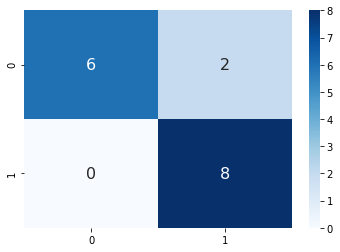

In [27]:
sns.heatmap(cm, annot = True, cmap = "Blues", annot_kws = {"size": 16})

# **Classification Report**

Classification report describes precision, recall, and f1-score as to each value. Many people regard accuracy and f1-score as the most important indicator to evaluate an AI model. This may be correct, but is not necessarily correct in the clinical field. **It must be considered why AI can be useful for and accepted by healthcare professionals. They expect that AI may be able to reduce their workload.** What does it mean to reduce their workload by AI? One idea is to **exclude lots of negative cases by AI that healthcare professionals would not have to see in order that they would be able to concentrate on the remaining positive cases to be treated**. Thus, it is required that the AI should be able to **exclude negative cases without false negatives**, which are actually positive but predicted as negative. **Otherwise, they would have to re-check the negative cases in order not to miss actually positive cases.** They must absolutely avoid clinical negligence! Therefore, **if the AI model does not give rise to false negative cases, the model will be considerably acceptable in the healthcare field** regardless of the accuracy or f1-score.

In [28]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



# **Analysing the Results**

It is crucial in the medical field to analyze what kinds of cases were misclassified by the AI model, because medical misdiagnosis must be avoided as much as possible. Thus, it is necessary to identify false positive and false negative cases. Making a data frame and confusion table can visualize the results. As discussed above, false negative cases must be particularly avoided.

In [29]:
confusion = []

for i, j in zip(y_true, y_pred):
  if i == 0 and j == 0:
    confusion.append('TN')
  elif i == 1 and j == 1:
    confusion.append('TP')
  elif i == 0 and j == 1:
    confusion.append('FP')
  else:
    confusion.append('FN')

In [30]:
confusion

['TN',
 'TN',
 'TN',
 'FP',
 'TN',
 'FP',
 'TN',
 'TN',
 'TP',
 'TP',
 'TP',
 'TP',
 'TP',
 'TP',
 'TP',
 'TP']

In [31]:
confusion_table = pd.DataFrame(data = confusion, columns = ["Results"])
confusion_table

,Results
0,TN
1,TN
2,TN
3,FP
4,TN
5,FP
6,TN
7,TN
8,TP
9,TP


In [32]:
confusion_table = pd.DataFrame({'Predicton':y_pred,
                                'Truth': y_true,
                                'Results': confusion})
confusion_table

,Predicton,Truth,Results
0,0,0,TN
1,0,0,TN
2,0,0,TN
3,1,0,FP
4,0,0,TN
5,1,0,FP
6,0,0,TN
7,0,0,TN
8,1,1,TP
9,1,1,TP


In [33]:
confusion_table.Results == 'FP'

0     False
1     False
2     False
3      True
4     False
5      True
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
Name: Results, dtype: bool

In [34]:
FPs = confusion_table[confusion_table['Results'] == 'FP']
FPs

,Predicton,Truth,Results
3,1,0,FP
5,1,0,FP


In [35]:
FNs = confusion_table[confusion_table['Results'] == 'FN']
FNs

,Predicton,Truth,Results


Here, a few false positive cases were observed, thus it is preferable to analyze why the AI model classified the normal cases as abnormal.The X-ray images look normal at all and the reason for the false positive was not clear. Therefore, in case this AI model is actually commercialized, it must be explained to physicians who use the AI that a few normal cases may be misclassified as pneumonia by the AI model.

In [36]:
normal_test_images = glob.glob(val_path + "/NORMAL/*.jpeg")
pneumonia_test_images = glob.glob(val_path + "/PNEUMONIA/*.jpeg")

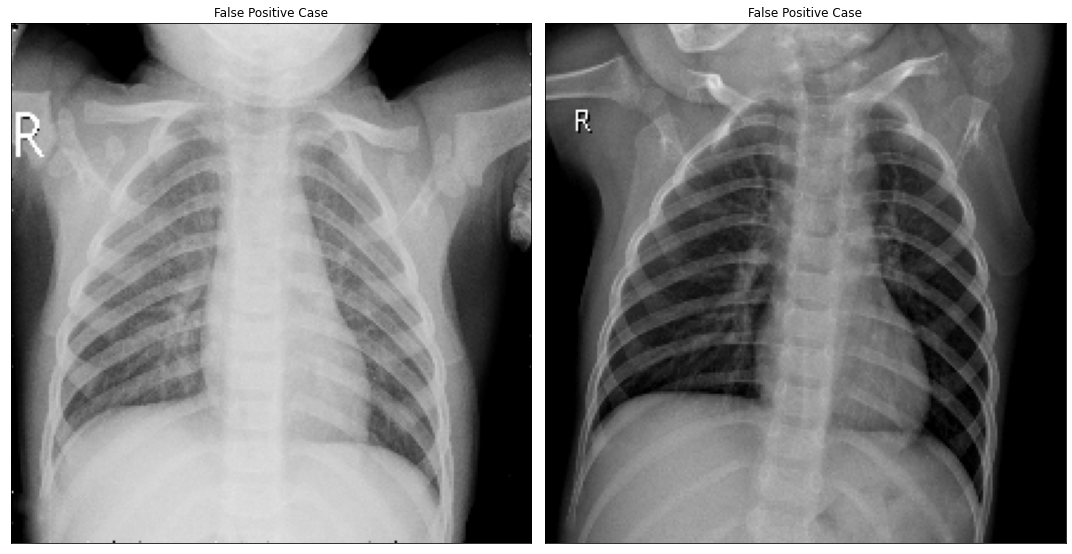

In [37]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in zip([3, 5], axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("False Positive Case")
fig.tight_layout()    

plt.show()

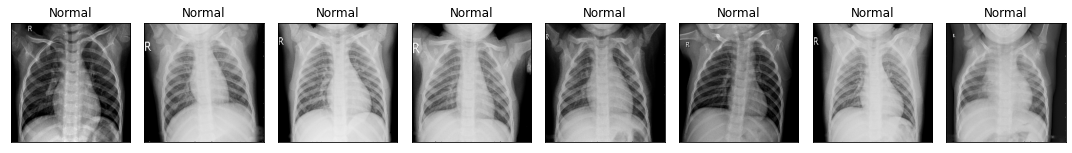

In [38]:
fig, axes = plt.subplots(nrows = 1, ncols = 8, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_test_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    

plt.show()

# **Conclusion**

This AI model may be useful for general physicians who occasionally see children to decide treatment. Further improvement is required to prevent misdiagnosis and unnecessary treatment.